In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_metric
import sys
sys.path.append("..")
from src.utils.text_processing import clean_text

In [3]:
wer_metric = load_metric("wer")

In [4]:
dev_df = pd.read_csv("../data/intron-dev-public-3231-clean.csv")
print(dev_df.shape)
dev_df.head(3)

(3231, 14)


,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_path,duration,origin,domain,split,gender
0,155349,659e36c14baaf7fa7bb197f951251f4b,setswana,26-40,BW,We should be asking ourselves whether we want ...,110,86ad3ef21e469217f28a749c990c81fd,/AfriSpeech-100/dev/92d2b94e-3e31-40be-b479-50...,8.400998,african,general,dev,Male
1,60812,1fd5f717cede9a867bf37d03c7d2166b,siswati,26-40,ZA,Other sagittal planes parallel to this off cen...,88,5409734bcc4a0f053e73f405d0f135da,/AfriSpeech-100/dev/127bdba1-8bc8-44a4-9c37-8e...,5.236984,african,clinical,dev,Female
2,139668,f2d08d2e1c47a187bfa6869fadc1f755,setswana,26-40,ZA,Tuberculoma is an intracranial massoccurring s...,109,b10dc4e959b6596d31866e5094ef500a,/AfriSpeech-100/dev/de0b1ee6-46f1-4eb6-a747-47...,7.072993,african,clinical,dev,Male


In [5]:
dev_df = dev_df[~dev_df.duplicated(subset="audio_path")]
print(dev_df.shape)

(3227, 14)


In [6]:
dev_df["audio_paths"] = dev_df["audio_path"].apply(lambda x: x.replace("/AfriSpeech-100/dev/", "/data/data/intron/"))
df = pd.read_csv("../results/intron-open-dev-whisper_medium-wer-0.3049-2872.csv")
df = pd.merge(df, dev_df, on="audio_paths")
df.shape

(2872, 22)

In [7]:
mapping_df = df[["idx", "audio_paths"]]
mapping_df.head(3)

,idx,audio_paths
0,72663,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...
1,153902,/data/data/intron/7ce31a48-f507-4344-bc49-96de...
2,82671,/data/data/intron/b8f6fbc1-426f-4a4b-99db-c38d...


In [8]:
models_df = pd.DataFrame()
models_df_clean = pd.DataFrame()

In [9]:
# Handy functions
def transform_raw_df(df_raw, columns=[], fmt="intron_whisper"):
    assert fmt != "" or fmt is not None
    
    df = df_raw.copy()
    
    if fmt == "intron_whisper":
        df = pd.merge(df, dev_df, on="audio_paths")
        df = pd.merge(df, mapping_df, on="idx")

        df = df[columns+["transcript", "hypothesis", "audio_paths_x", "accent_x"]]
        df.loc[:, "accent"] = df.loc[:, "accent_x"]
        df.loc[:, "audio_paths"] = df.loc[:, "audio_paths_x"]
        df.loc[:, "reference"] = df.loc[:, "transcript"]
        df.loc[:, "prediction"] = df.loc[:, "hypothesis"]
        df = df.drop(columns=["accent_x", "audio_paths_x", "hypothesis", "transcript"])
    
    elif fmt == "african_nlp":
        df = pd.merge(df, dev_df, on="audio_paths")
        df = pd.merge(df, mapping_df, on="idx")

        df = df[columns+["accent", "user_ids", "transcript", 1]]
        df.loc[:, "reference"] = df.loc[:, "transcript"]
        df.loc[:, "prediction"] = df.loc[:, 1]
        df = df.drop(columns=[1, "transcript"])

    elif fmt == "aws":
        df = pd.merge(df[["idx", "transcript", "predictions"]], dev_df, on="idx")
        df = pd.merge(df, mapping_df, on="idx")

        df = df[columns+["accent", "user_ids", "transcript_x", "predictions"]]
        df.loc[:, "reference"] = df.loc[:, "transcript_x"]
        df.loc[:, "prediction"] = df.loc[:, "predictions"]
        df = df.drop(columns=["transcript_x", "predictions"])

    elif fmt == "azure":
        df = pd.merge(df[["idx", "transcript", "predictions_raw"]], dev_df, on="idx")
        df = pd.merge(df, mapping_df, on="idx")

        df = df[columns+["accent", "user_ids", "transcript_x", "predictions_raw"]]
        df.loc[:, "reference"] = df.loc[:, "transcript_x"]
        df.loc[:, "prediction"] = df.loc[:, "predictions_raw"]
        df = df.drop(columns=["transcript_x", "predictions_raw"])
    
    elif fmt == "wav2vec2":
        df.loc[:, "audio_paths"] = df["audio_path"]
        df = pd.merge(df[["audio_paths", "text", "predictions_raw"]], dev_df, on="audio_paths")
        df = pd.merge(df, mapping_df, on="idx")

        df = df[columns+["accent", "user_ids", "text", "predictions_raw"]]
        df.loc[:, "reference"] = df.loc[:, "text"]
        df.loc[:, "prediction"] = df.loc[:, "predictions_raw"]
        df = df.drop(columns=["text", "predictions_raw"])
    
    elif fmt in df.columns:
        df = pd.merge(df[["idx", "transcript", fmt]], dev_df, on="idx")
        df = pd.merge(df, mapping_df, on="idx")

        df = df[columns+["accent", "user_ids", "transcript_x", fmt]]
        df.loc[:, "reference"] = df.loc[:, "transcript_x"]
        df.loc[:, "prediction"] = df.loc[:, fmt]
        df = df.drop(columns=["transcript_x", fmt])
  
    else:
        raise NotImplementedError()
    
    print(df.shape)
    df["wer"] = df.apply(lambda x: wer_metric.compute(predictions=[x.prediction], references=[x.reference]), axis=1) 
    return df
    


def clean_and_compute_wer(df):
    df_clean = df.copy()
    
    print(df_clean[df_clean["prediction"].isnull()].shape)
    
    df_clean["prediction"] = df_clean["prediction"].fillna("")
    print(df_clean[df_clean["prediction"].isnull()].shape)
    
    df_clean["reference"] = df_clean["reference"].apply(lambda x: clean_text(x))
    df_clean["prediction"] = df_clean["prediction"].apply(lambda x: clean_text(x))
    
    df_clean["wer"] = df_clean.apply(lambda x: wer_metric.compute(predictions=[x.prediction], 
                                                                  references=[x.reference]), axis=1)
    return df_clean
    
    
def write_to_folder(model_id_or_path, predictions_df, output_dir="../results/", split="dev"):
    wer = predictions_df["wer"].mean()
    output_path = f"{output_dir}/intron-open-{split}-{model_id_or_path}-wer-{round(wer, 4)}-{len(predictions_df)}.csv"
    predictions_df.to_csv(output_path, index=False)

In [10]:
# make output dir
import os
os.makedirs("../results/raw", exist_ok=True)
os.makedirs("../results/normalized", exist_ok=True)

# Compute WER

## OpenAI

In [11]:
whspr = pd.read_csv("../results/whisper_wer_asr_dev.csv")
print(whspr.shape)
whspr.head(3)

(3232, 10)


,Unnamed: 0,idx,user_ids,transcript,whisper_medium,whisper_large,wer,cleanup_references,cleanup_whisper,wer_cleanup
0,0,72663,f559cb4f16bc465ea44b56a8d3b5513e,Ensure the correct placement of the feeding tu...,Ensure the correct placement of the feeding t...,Ensure the correct placement of the feeding t...,0.451613,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,0.290323
1,1,153902,2be9bc423e70a24c703f8336e60af3f3,"Regardlessof how amyocyteis stimulated,however...","Regardless of how amyokites stimulated, howev...","Regardless of how a myocardial stimulation, h...",0.444444,regardlessof how amyocyteis stimulated however...,regardless of how amyokites stimulated howeve...,0.250000
2,2,82671,a3c2c182b6b53089ef4bc3eccff103bf,"For Nigeria to achieve similar noble goals, th...","For Nigeria to achieve similar noble goals, t...","For Nigeria to achieve similar noble goals, t...",0.222222,for nigeria to achieve similar noble goals th...,for nigeria to achieve similar noble goals th...,0.027778


In [12]:
columns = ["idx", "domain", "gender", "duration", "age_group"]

### Whisper-Large

In [13]:
whspr_large = transform_raw_df(whspr, columns=columns, fmt="whisper_large")
whspr_large_clean = clean_and_compute_wer(whspr_large)

(2872, 9)
(3, 10)
(0, 10)


In [14]:
whspr_large.head(2)

,idx,domain,gender,duration,age_group,accent,user_ids,reference,prediction,wer
0,72663,clinical,Female,16.421995,19-25,swahili,f559cb4f16bc465ea44b56a8d3b5513e,Ensure the correct placement of the feeding tu...,Ensure the correct placement of the feeding t...,0.290323
1,153902,clinical,Female,11.393991,19-25,swahili,2be9bc423e70a24c703f8336e60af3f3,"Regardlessof how amyocyteis stimulated,however...","Regardless of how a myocardial stimulation, h...",0.500000


In [15]:
whspr_large_clean.head(2)

,idx,domain,gender,duration,age_group,accent,user_ids,reference,prediction,wer
0,72663,clinical,Female,16.421995,19-25,swahili,f559cb4f16bc465ea44b56a8d3b5513e,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,0.290323
1,153902,clinical,Female,11.393991,19-25,swahili,2be9bc423e70a24c703f8336e60af3f3,"regardlessof how amyocyteis stimulated,however...","regardless of how a myocardial stimulation, ho...",0.500000


In [16]:
# WER
print(whspr_large["wer"].mean())
print(whspr_large_clean["wer"].mean())

0.5039740585544689
0.4108835197703194


In [17]:
model_id_or_path = "openai_whisper_large"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_large, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_large_clean,
                output_dir="../results/normalized")

In [18]:
whspr_large["name"] = "openai_whisper_large"
whspr_large_clean["name"] = "openai_whisper_large"

models_df = pd.concat([models_df, whspr_large])
models_df_clean = pd.concat([models_df_clean, whspr_large_clean])

### Whisper-Medium

In [19]:
whspr_medium_raw = pd.read_csv("../results/intron-open-dev-whisper_medium-wer-0.3049-2872.csv")
print(whspr_medium_raw.shape)
whspr_medium_raw.head(2)

(2872, 8)


,hypothesis,reference,audio_paths,accent,pred_clean,ref_clean,hypothesis_clean,reference_clean
0,Ensure the correct placement of the feeding tu...,Ensure the correct placement of the feeding tu...,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...,swahili,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...
1,"Regardless of how amyokites stimulated, howeve...","Regardlessof how amyocyteis stimulated,however...",/data/data/intron/7ce31a48-f507-4344-bc49-96de...,swahili,"regardless of how amyokites stimulated, howeve...","regardlessof how amyocyteis stimulated,however...",regardless of how amyokites stimulated however...,regardlessof how amyocyteis stimulated however...


In [20]:
whspr_medium = transform_raw_df(whspr_medium_raw, columns=columns, fmt="intron_whisper")
whspr_medium_clean = clean_and_compute_wer(whspr_medium)

(2872, 9)
(0, 10)
(0, 10)


In [21]:
# WER
print(whspr_medium["wer"].mean())
print(whspr_medium_clean["wer"].mean())

0.4643886864352219
0.34914988813403375


In [22]:
model_id_or_path = "openai_whisper_medium"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_medium, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_medium_clean,
                output_dir="../results/normalized")

In [23]:
whspr_medium["name"] = "openai_whisper_medium"
whspr_medium_clean["name"] = "openai_whisper_medium"

models_df = pd.concat([models_df, whspr_medium])
models_df_clean = pd.concat([models_df_clean, whspr_medium_clean])

In [24]:
whspr_medium_en_raw = pd.read_csv("../results/intron-open-dev-whisper_medium.en-wer-0.3219-2872.csv")
print(whspr_medium_en_raw.shape)
whspr_medium_en = transform_raw_df(whspr_medium_en_raw, columns=columns, fmt="intron_whisper")
whspr_medium_en_clean = clean_and_compute_wer(whspr_medium_en)

(2872, 8)
(2872, 9)
(0, 10)
(0, 10)


In [25]:
print(whspr_medium_en["wer"].mean())
print(whspr_medium_en_clean["wer"].mean())

0.46137424273526506
0.3678484564644302


In [26]:
model_id_or_path = "openai_whisper_medium_en"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_medium_en, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_medium_en_clean,
                output_dir="../results/normalized")

In [27]:
whspr_medium_en["name"] = "openai_whisper_medium_en"
whspr_medium_en_clean["name"] = "openai_whisper_medium_en"

models_df = pd.concat([models_df, whspr_medium_en])
models_df_clean = pd.concat([models_df_clean, whspr_medium_en_clean])

### Whisper-Small

In [28]:
whspr_small_raw = pd.read_csv("../results/intron-open-dev-whisper_small-wer-0.3743-2872.csv")
print(whspr_small_raw.shape)
whspr_small_raw.head(2)

(2872, 8)


,hypothesis,reference,audio_paths,accent,pred_clean,ref_clean,hypothesis_clean,reference_clean
0,Ensure the correct placement of the feeding tu...,Ensure the correct placement of the feeding tu...,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...,swahili,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...
1,"Regardless of how a moeocatase stimulated, how...","Regardlessof how amyocyteis stimulated,however...",/data/data/intron/7ce31a48-f507-4344-bc49-96de...,swahili,"regardless of how a moeocatase stimulated, how...","regardlessof how amyocyteis stimulated,however...",regardless of how a moeocatase stimulated howe...,regardlessof how amyocyteis stimulated however...


In [29]:
whspr_small = transform_raw_df(whspr_small_raw, columns=columns, fmt="intron_whisper")
whspr_small_clean = clean_and_compute_wer(whspr_small)

(2872, 9)
(0, 10)
(0, 10)


In [30]:
print(whspr_small["wer"].mean())
print(whspr_small_clean["wer"].mean())

0.5337821026197487
0.43133830977562343


In [31]:
model_id_or_path = "openai_whisper_small"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_small, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_small_clean,
                output_dir="../results/normalized")

In [32]:
whspr_small["name"] = "openai_whisper_small"
whspr_small_clean["name"] = "openai_whisper_small"

models_df = pd.concat([models_df, whspr_small])
models_df_clean = pd.concat([models_df_clean, whspr_small_clean])

In [33]:
whspr_small_en_raw = pd.read_csv("../results/intron-open-dev-whisper_small.en-wer-0.383-2872.csv")
print(whspr_small_en_raw.shape)
whspr_small_en = transform_raw_df(whspr_small_en_raw, columns=columns, fmt="intron_whisper")
whspr_small_en_clean = clean_and_compute_wer(whspr_small_en)

(2872, 8)
(2872, 9)
(0, 10)
(0, 10)


In [34]:
print(whspr_small_en["wer"].mean())
print(whspr_small_en_clean["wer"].mean())

0.519713022377241
0.43402733892570033


In [35]:
model_id_or_path = "openai_whisper_small_en"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_small_en, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=whspr_small_en_clean,
                output_dir="../results/normalized")

In [36]:
whspr_small_en["name"] = "openai_whisper_small_en"
whspr_small_en_clean["name"] = "openai_whisper_small_en"

models_df = pd.concat([models_df, whspr_small_en])
models_df_clean = pd.concat([models_df_clean, whspr_small_en_clean])

In [37]:
models_df.shape, models_df_clean.shape

((14360, 12), (14360, 12))

## Nvidia

### Nemo-conformer-ctc-large

In [38]:
nemo_ctc_raw = pd.read_csv("../results/african-nlp-nemo-ctc-predictons", header=None, delimiter="	")
nemo_ctc_raw["audio_paths"] = nemo_ctc_raw[0].apply(lambda x: x.replace("/scratch/pbsjobs/axy327/dev/", "/data/data/intron/"))
print(nemo_ctc_raw.shape)
nemo_ctc_raw.head(2)

(3227, 3)


,0,1,audio_paths
0,/scratch/pbsjobs/axy327/dev/a25d5981-d814-4eef...,construction and sea trials,/data/data/intron/a25d5981-d814-4eef-8637-cc35...
1,/scratch/pbsjobs/axy327/dev/35a17e2f-5b12-4886...,unstable bos fracture of unspecified thoracic ...,/data/data/intron/35a17e2f-5b12-4886-ad2c-c1aa...


In [39]:
nemo_ctc = transform_raw_df(nemo_ctc_raw, columns=columns, fmt="african_nlp")
nemo_ctc_clean = clean_and_compute_wer(nemo_ctc)

(2872, 9)
(2, 10)
(0, 10)


In [40]:
print(nemo_ctc["wer"].mean())
print(nemo_ctc_clean["wer"].mean())

0.6767011051916588
0.5503160383940416


In [41]:
model_id_or_path = "nvidia_nemo_conformer_ctc_large"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=nemo_ctc, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=nemo_ctc_clean,
                output_dir="../results/normalized")

In [42]:
nemo_ctc["name"] = "nvidia_nemo_conformer_ctc_large"
nemo_ctc_clean["name"] = "nvidia_nemo_conformer_ctc_large"

models_df = pd.concat([models_df, nemo_ctc])
models_df_clean = pd.concat([models_df_clean, nemo_ctc_clean])

### Nemo-conformer-transducer-large

In [43]:
nemo_transducer_raw = pd.read_csv("../results/african-nlp-nemo-transducer-predictons", header=None, delimiter="	")
nemo_transducer_raw["audio_paths"] = nemo_transducer_raw[0].apply(lambda x: x.replace("/scratch/pbsjobs/axy327/dev/", "/data/data/intron/"))
print(nemo_transducer_raw.shape)
nemo_transducer_raw.head(2)

(3227, 3)


,0,1,audio_paths
0,/scratch/pbsjobs/axy327/dev/a25d5981-d814-4eef...,construction and sea trials,/data/data/intron/a25d5981-d814-4eef-8637-cc35...
1,/scratch/pbsjobs/axy327/dev/35a17e2f-5b12-4886...,unstable boss fracture of unspecified thoracic...,/data/data/intron/35a17e2f-5b12-4886-ad2c-c1aa...


In [44]:
nemo_transducer = transform_raw_df(nemo_transducer_raw, columns=columns, fmt="african_nlp")
nemo_transducer_clean = clean_and_compute_wer(nemo_transducer)

(2872, 9)
(6, 10)
(0, 10)


In [45]:
print(nemo_transducer["wer"].mean())
print(nemo_transducer_clean["wer"].mean())

0.6637992751483184
0.5245269422772046


In [46]:
model_id_or_path = "nvidia_nemo_conformer_transducer_large"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=nemo_transducer, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=nemo_transducer_clean,
                output_dir="../results/normalized")

In [47]:
nemo_transducer["name"] = "nvidia_nemo_conformer_transducer_large"
nemo_transducer_clean["name"] = "nvidia_nemo_conformer_transducer_large"

models_df = pd.concat([models_df, nemo_transducer])
models_df_clean = pd.concat([models_df_clean, nemo_transducer_clean])

## Speech Brain

In [48]:
speech_brain_raw = pd.read_csv("../results/african-nlp-speechbrain-predictons", header=None, delimiter="	")
speech_brain_raw["audio_paths"] = nemo_transducer_raw[0].apply(lambda x: x.replace("/scratch/pbsjobs/axy327/dev/", "/data/data/intron/"))
print(speech_brain_raw.shape)
speech_brain_raw.head(2)

(3227, 3)


,0,1,audio_paths
0,/scratch/pbsjobs/axy327/dev/a25d5981-d814-4eef...,CONSTRUCTION AND C TRIALS,/data/data/intron/a25d5981-d814-4eef-8637-cc35...
1,/scratch/pbsjobs/axy327/dev/35a17e2f-5b12-4886...,STUBBLE BOSS RUPTURE OF OSPREY'S WIFE'S THORAC...,/data/data/intron/35a17e2f-5b12-4886-ad2c-c1aa...


In [49]:
speech_brain = transform_raw_df(speech_brain_raw, columns=columns, fmt="african_nlp")
speech_brain_clean = clean_and_compute_wer(speech_brain)

(2872, 9)
(1, 10)
(0, 10)


In [50]:
print(speech_brain["wer"].mean())
print(speech_brain_clean["wer"].mean())

1.3610988905098031
0.976453580724285


In [51]:
model_id_or_path="speechbrain_crdnn_rnnlm_librispeech"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=speech_brain, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=speech_brain_clean,
                output_dir="../results/normalized")

In [52]:
speech_brain["name"] = "speechbrain_crdnn_rnnlm_librispeech"
speech_brain_clean["name"] = "speechbrain_crdnn_rnnlm_librispeech"

models_df = pd.concat([models_df, speech_brain])
models_df_clean = pd.concat([models_df_clean, speech_brain_clean])

## AWS

### Medical API (Primary Care)

In [53]:
aws_medical_raw = pd.read_csv("../results/intron-open-dev-aws-transcribe-medical-wer-0.5544-3232.csv")
print(aws_medical_raw.shape)
aws_medical_raw.head(2)

(3232, 15)


,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,split,predictions,wer
0,72663,f559cb4f16bc465ea44b56a8d3b5513e,swahili,19-25,KE,Ensure the correct placement of the feeding tu...,206,29af500daee748498b3329352fbc170a,/AfriSpeech-100/dev/e809b58c-4f05-4754-b98c-fb...,16.421995,african,clinical,dev,ensure the correct placement of the feeding tu...,0.451613
1,153902,2be9bc423e70a24c703f8336e60af3f3,swahili,19-25,KE,"Regardlessof how amyocyteis stimulated,however...",143,b87324a3c5ca065494f385e4f49e4b23,/AfriSpeech-100/dev/7ce31a48-f507-4344-bc49-96...,11.393991,african,clinical,dev,"regardless of how a market is stimulated, howe...",0.555556


In [54]:
aws_medical = transform_raw_df(aws_medical_raw, columns=columns, fmt="aws")
aws_medical_clean = clean_and_compute_wer(aws_medical)

(2872, 9)
(1, 10)
(0, 10)


In [55]:
print(aws_medical["wer"].mean())
print(aws_medical_clean["wer"].mean())

0.6347359704426636
0.5358062344446374


In [56]:
model_id_or_path="amazon_aws_transcribe_medical_api_primary_care"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=aws_medical, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=aws_medical_clean,
                output_dir="../results/normalized")

In [57]:
aws_medical["name"] = "amazon_aws_transcribe_medical_api_primary_care"
aws_medical_clean["name"] = "amazon_aws_transcribe_medical_api_primary_care"

models_df = pd.concat([models_df, aws_medical])
models_df_clean = pd.concat([models_df_clean, aws_medical_clean])

### Non-medical API

In [58]:
aws_raw = pd.read_csv("../results/intron-open-dev-aws-transcribe-wer-0.5212-3232.csv")
print(aws_raw.shape)
aws_raw.head(2)

(3232, 15)


,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,split,predictions,wer
0,72663,f559cb4f16bc465ea44b56a8d3b5513e,swahili,19-25,KE,Ensure the correct placement of the feeding tu...,206,29af500daee748498b3329352fbc170a,/AfriSpeech-100/dev/e809b58c-4f05-4754-b98c-fb...,16.421995,african,clinical,dev,ensure the correct placement of the feeding tu...,0.516129
1,153902,2be9bc423e70a24c703f8336e60af3f3,swahili,19-25,KE,"Regardlessof how amyocyteis stimulated,however...",143,b87324a3c5ca065494f385e4f49e4b23,/AfriSpeech-100/dev/7ce31a48-f507-4344-bc49-96...,11.393991,african,clinical,dev,"regardless of how a market is stimulated, howe...",0.555556


In [59]:
aws = transform_raw_df(aws_raw, columns=columns, fmt="aws")
aws_clean = clean_and_compute_wer(aws)

(2872, 9)
(7, 10)
(0, 10)


In [60]:
print(aws["wer"].mean())
print(aws_clean["wer"].mean())

0.5992453253269371
0.49882406211336133


In [61]:
model_id_or_path="amazon_aws_transcribe_api"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=aws, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=aws_clean,
                output_dir="../results/normalized")

In [62]:
aws["name"] = "amazon_aws_transcribe_api"
aws_clean["name"] = "amazon_aws_transcribe_api"

models_df = pd.concat([models_df, aws])
models_df_clean = pd.concat([models_df_clean, aws_clean])

## Google

### GCP Speech Non-medical API

In [63]:
gcp_raw = pd.read_csv("../results/gcp_wer_asr_dev.csv")
print(gcp_raw.shape)
gcp_raw.head(2)

(3232, 9)


,Unnamed: 0,idx,user_ids,transcript,gcp,wer,cleanup_references,cleanup_gcp,wer_cleanup
0,0,72663,f559cb4f16bc465ea44b56a8d3b5513e,Ensure the correct placement of the feeding tu...,cancel the correct placement of the feeding tu...,0.580645,ensure the correct placement of the feeding tu...,cancel the correct placement of the feeding tu...,0.580645
1,1,153902,2be9bc423e70a24c703f8336e60af3f3,"Regardlessof how amyocyteis stimulated,however...",regardless of how American cheese stimulated a...,0.722222,regardlessof how amyocyteis stimulated however...,regardless of how american cheese stimulated a...,0.550000


In [64]:
gcp = transform_raw_df(gcp_raw, columns=columns, fmt="gcp")
gcp_clean = clean_and_compute_wer(gcp)

(2872, 9)
(85, 10)
(0, 10)


In [65]:
print(gcp["wer"].mean())
print(gcp_clean["wer"].mean())

0.6566726487334155
0.5993110736614581


In [66]:
model_id_or_path="google_gcp_speech_api"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=gcp, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=gcp_clean,
                output_dir="../results/normalized")

In [67]:
gcp["name"] = "google_gcp_speech_api"
gcp_clean["name"] = "google_gcp_speech_api"

models_df = pd.concat([models_df, gcp])
models_df_clean = pd.concat([models_df_clean, gcp_clean])

## Microsoft

### Azure

In [68]:
azure_raw = pd.read_csv("../results/intron-open-dev-azure-transcribe-wer-0.5038-2883.csv")
print(azure_raw.shape)
azure_raw.head(2)

(2883, 16)


,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,split,predictions_raw,predictions,wer
0,72663,f559cb4f16bc465ea44b56a8d3b5513e,swahili,19-25,KE,Ensure the correct placement of the feeding tu...,206,29af500daee748498b3329352fbc170a,/AfriSpeech-100/dev/e809b58c-4f05-4754-b98c-fb...,16.421995,african,clinical,dev,Ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,0.290323
1,153902,2be9bc423e70a24c703f8336e60af3f3,swahili,19-25,KE,"Regardlessof how amyocyteis stimulated,however...",143,b87324a3c5ca065494f385e4f49e4b23,/AfriSpeech-100/dev/7ce31a48-f507-4344-bc49-96...,11.393991,african,clinical,dev,"Regardless of how America is stimulated, howev...","regardless of how america is stimulated, howev...",0.500000


In [69]:
azure = transform_raw_df(azure_raw, columns=columns, fmt="azure")
azure_clean = clean_and_compute_wer(azure)

(2872, 9)
(501, 10)
(0, 10)


In [70]:
print(azure["wer"].mean())
print(azure_clean["wer"].mean())

0.5948180547456207
0.5169678167305342


In [71]:
model_id_or_path="microsoft_azure_speech_api"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=azure, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=azure_clean,
                output_dir="../results/normalized")

In [72]:
azure["name"] = "microsoft_azure_speech_api"
azure_clean["name"] = "microsoft_azure_speech_api"

models_df = pd.concat([models_df, azure])
models_df_clean = pd.concat([models_df_clean, azure_clean])

In [73]:
models_df.shape, models_df_clean.shape

((34464, 12), (34464, 12))

### WavLm-libri-clean-100h-large

In [74]:
wavlm_libri_clean_100h_large_raw = pd.read_csv("../results/intron-open-dev-ful-patrickvonplaten-wavlm-libri-clean-100h-large-wer-0.6938-3232.csv")
print(wavlm_libri_clean_100h_large_raw.shape)
wavlm_libri_clean_100h_large_raw.head(2)

(3232, 7)


,audio_path,text,reference,predictions,predictions_raw,wer,accent
0,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...,Ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,enshured the corect placement of the feiding t...,enshured the corect placement of the feiding t...,0.806452,swahili
1,/data/data/intron/7ce31a48-f507-4344-bc49-96de...,"Regardlessof how amyocyteis stimulated,however...","regardlessof how amyocyteis stimulated,however...",regadless of how amocety stimulated however th...,regadless of how amocety stimulated however th...,0.666667,swahili


In [75]:
wavlm_libri_clean_100h_large = transform_raw_df(wavlm_libri_clean_100h_large_raw, columns=columns, fmt="wav2vec2")
wavlm_libri_clean_100h_large_clean = clean_and_compute_wer(wavlm_libri_clean_100h_large)

(2877, 9)
(1, 10)
(0, 10)


In [76]:
print(wavlm_libri_clean_100h_large["wer"].mean())
print(wavlm_libri_clean_100h_large_clean["wer"].mean())

0.8328127595669096
0.7692137602897249


In [77]:
model_id_or_path="microsoft_wavlm_libri_clean_100h_large"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wavlm_libri_clean_100h_large, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wavlm_libri_clean_100h_large_clean,
                output_dir="../results/normalized")

In [78]:
wavlm_libri_clean_100h_large["name"] = "microsoft_wavlm_libri_clean_100h_large"
wavlm_libri_clean_100h_large_clean["name"] = "microsoft_wavlm_libri_clean_100h_large"

models_df = pd.concat([models_df, wavlm_libri_clean_100h_large])
models_df_clean = pd.concat([models_df_clean, wavlm_libri_clean_100h_large_clean])

### WavLm-libri-clean-100h-base-plus

In [79]:
wavlm_libri_clean_100h_base_raw = pd.read_csv("../results/wavLM_wer_asr_dev.csv")
print(wavlm_libri_clean_100h_base_raw.shape)
wavlm_libri_clean_100h_base_raw.head(2)

(3232, 9)


,Unnamed: 0,idx,user_ids,transcript,wavLM,wer,cleanup_references,cleanup_wavLM,wer_cleanup
0,0,72663,f559cb4f16bc465ea44b56a8d3b5513e,Ensure the correct placement of the feeding tu...,ensu the correct placement of the fiding tube ...,0.903226,ensure the correct placement of the feeding tu...,ensu the correct placement of the fiding tube ...,0.83871
1,1,153902,2be9bc423e70a24c703f8336e60af3f3,"Regardlessof how amyocyteis stimulated,however...",regardless of how amuketisstimulated however t...,0.722222,regardlessof how amyocyteis stimulated however...,regardless of how amuketisstimulated however t...,0.60000


In [80]:
wavlm_libri_clean_100h_base = transform_raw_df(wavlm_libri_clean_100h_base_raw, columns=columns, fmt="wavLM")
wavlm_libri_clean_100h_base_clean = clean_and_compute_wer(wavlm_libri_clean_100h_base)

(2872, 9)
(2, 10)
(0, 10)


In [81]:
print(wavlm_libri_clean_100h_base["wer"].mean())
print(wavlm_libri_clean_100h_base_clean["wer"].mean())

0.9022293171522732
0.8549641714400352


In [82]:
model_id_or_path="microsoft_wavlm_libri_clean_100h_base"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wavlm_libri_clean_100h_base, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wavlm_libri_clean_100h_base_clean,
                output_dir="../results/normalized")

In [83]:
wavlm_libri_clean_100h_base["name"] = "microsoft_wavlm_libri_clean_100h_base"
wavlm_libri_clean_100h_base_clean["name"] = "microsoft_wavlm_libri_clean_100h_base"

models_df = pd.concat([models_df, wavlm_libri_clean_100h_base])
models_df_clean = pd.concat([models_df_clean, wavlm_libri_clean_100h_base_clean])

## Facebook

### Wav2vec2-large-xlsr-53-english

In [84]:
wav2vec2_large_xlsr_53_english_raw = pd.read_csv("../results/intron-open-dev-ful-jonatasgrosman-wav2vec2-large-xlsr-53-english-wer-0.5606-3232.csv")
print(wav2vec2_large_xlsr_53_english_raw.shape)
wav2vec2_large_xlsr_53_english_raw.head(2)

(3232, 7)


,audio_path,text,reference,predictions,predictions_raw,wer,accent
0,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...,Ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the correct replacement of the feeding ...,ensure the correct replacement of the feeding ...,0.709677,swahili
1,/data/data/intron/7ce31a48-f507-4344-bc49-96de...,"Regardlessof how amyocyteis stimulated,however...","regardlessof how amyocyteis stimulated,however...",regardless of how amerchetis stimulated howeve...,regardless of how amerchetis stimulated howeve...,0.611111,swahili


In [85]:
wav2vec2_large_xlsr_53_english = transform_raw_df(wav2vec2_large_xlsr_53_english_raw, columns=columns, fmt="wav2vec2")
wav2vec2_large_xlsr_53_english_clean = clean_and_compute_wer(wav2vec2_large_xlsr_53_english)

(2877, 9)
(1, 10)
(0, 10)


In [86]:
print(wav2vec2_large_xlsr_53_english["wer"].mean())
print(wav2vec2_large_xlsr_53_english_clean["wer"].mean())

0.7152722570406036
0.6398663107153179


In [87]:
model_id_or_path="facebook_wav2vec2_large_xlsr_53_english"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_large_xlsr_53_english, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_large_xlsr_53_english_clean,
                output_dir="../results/normalized")

In [88]:
wav2vec2_large_xlsr_53_english["name"] = "facebook_wav2vec2_large_xlsr_53_english"
wav2vec2_large_xlsr_53_english_clean["name"] = "facebook_wav2vec2_large_xlsr_53_english"

models_df = pd.concat([models_df, wav2vec2_large_xlsr_53_english])
models_df_clean = pd.concat([models_df_clean, wav2vec2_large_xlsr_53_english_clean])

### Wav2vec2-xls-r-1b-english

In [89]:
wav2vec2_xls_r_1b_english_raw = pd.read_csv("../results/intron-open-dev-ful-jonatasgrosman-wav2vec2-xls-r-1b-english-wer-0.5761-3232.csv")
print(wav2vec2_xls_r_1b_english_raw.shape)
wav2vec2_xls_r_1b_english_raw.head(2)

(3232, 7)


,audio_path,text,reference,predictions,predictions_raw,wer,accent
0,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...,Ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the correct replacement of the feeding ...,ensure the correct replacement of the feeding ...,0.709677,swahili
1,/data/data/intron/7ce31a48-f507-4344-bc49-96de...,"Regardlessof how amyocyteis stimulated,however...","regardlessof how amyocyteis stimulated,however...",regardless of how amceteis stimulated however ...,regardless of how amceteis stimulated however ...,0.611111,swahili


In [90]:
wav2vec2_xls_r_1b_english = transform_raw_df(wav2vec2_xls_r_1b_english_raw, columns=columns, fmt="wav2vec2")
wav2vec2_xls_r_1b_english_clean = clean_and_compute_wer(wav2vec2_xls_r_1b_english)

(2877, 9)
(0, 10)
(0, 10)


In [91]:
print(wav2vec2_xls_r_1b_english["wer"].mean())
print(wav2vec2_xls_r_1b_english_clean["wer"].mean())

0.743025983322594
0.6514921574251561


In [92]:
model_id_or_path="facebook_wav2vec2_xls_r_1b_english"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_xls_r_1b_english, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_xls_r_1b_english_clean,
                output_dir="../results/normalized")

In [93]:
wav2vec2_xls_r_1b_english["name"] = "facebook_wav2vec2_xls_r_1b_english"
wav2vec2_xls_r_1b_english_clean["name"] = "facebook_wav2vec2_xls_r_1b_english"

models_df = pd.concat([models_df, wav2vec2_xls_r_1b_english])
models_df_clean = pd.concat([models_df_clean, wav2vec2_xls_r_1b_english_clean])

### Wav2vec2-large-960h-lv60-self

In [94]:
wav2vec2_large_960h_lv60_self_raw = pd.read_csv("../results/intron-open-dev-ful-facebook-wav2vec2-large-960h-lv60-self-wer-0.5944-3232.csv")
print(wav2vec2_large_960h_lv60_self_raw.shape)
wav2vec2_large_960h_lv60_self_raw.head(2)

(3232, 7)


,audio_path,text,reference,predictions,predictions_raw,wer,accent
0,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...,Ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the correct eplacement of the feeding t...,ENSURE THE CORRECT EPLACEMENT OF THE FEEDING T...,0.645161,swahili
1,/data/data/intron/7ce31a48-f507-4344-bc49-96de...,"Regardlessof how amyocyteis stimulated,however...","regardlessof how amyocyteis stimulated,however...",regardless of how amikitas stimulated however ...,REGARDLESS OF HOW AMIKITAS STIMULATED HOWEVER ...,0.666667,swahili


In [95]:
wav2vec2_large_960h_lv60_self = transform_raw_df(wav2vec2_large_960h_lv60_self_raw, columns=columns, fmt="wav2vec2")
wav2vec2_large_960h_lv60_self_clean = clean_and_compute_wer(wav2vec2_large_960h_lv60_self)

(2877, 9)
(1, 10)
(0, 10)


In [96]:
print(wav2vec2_large_960h_lv60_self["wer"].mean())
print(wav2vec2_large_960h_lv60_self_clean["wer"].mean())

1.2229264243916067
0.67118697565761


In [97]:
model_id_or_path="facebook_wav2vec2_large_960h_lv60_self"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_large_960h_lv60_self, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_large_960h_lv60_self_clean,
                output_dir="../results/normalized")

In [98]:
wav2vec2_large_960h_lv60_self["name"] = "facebook_wav2vec2_large_960h_lv60_self"
wav2vec2_large_960h_lv60_self_clean["name"] = "facebook_wav2vec2_large_960h_lv60_self"

models_df = pd.concat([models_df, wav2vec2_large_960h_lv60_self])
models_df_clean = pd.concat([models_df_clean, wav2vec2_large_960h_lv60_self_clean])

### Wav2vec2-large-960h

In [99]:
wav2vec2_large_960h_raw = pd.read_csv("../results/intron-open-dev-ful-facebook-wav2vec2-large-960h-wer-0.7031-3232.csv")
print(wav2vec2_large_960h_raw.shape)
wav2vec2_large_960h_raw.head(2)

(3232, 7)


,audio_path,text,reference,predictions,predictions_raw,wer,accent
0,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...,Ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ENSURE THE CORRECT PLACEMENT OF THE FEEDING TU...,0.741935,swahili
1,/data/data/intron/7ce31a48-f507-4344-bc49-96de...,"Regardlessof how amyocyteis stimulated,however...","regardlessof how amyocyteis stimulated,however...",regardless of how amercitis stimulated however...,REGARDLESS OF HOW AMERCITIS STIMULATED HOWEVER...,0.666667,swahili


In [100]:
wav2vec2_large_960h = transform_raw_df(wav2vec2_large_960h_raw, columns=columns, fmt="wav2vec2")
wav2vec2_large_960h_clean = clean_and_compute_wer(wav2vec2_large_960h)

(2877, 9)
(1, 10)
(0, 10)


In [101]:
print(wav2vec2_large_960h["wer"].mean())
print(wav2vec2_large_960h_clean["wer"].mean())

1.246550763360166
0.789551281262618


In [102]:
model_id_or_path="facebook_wav2vec2_large_960h"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_large_960h, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_large_960h_clean,
                output_dir="../results/normalized")

In [103]:
wav2vec2_large_960h["name"] = "facebook_wav2vec2_large_960h"
wav2vec2_large_960h_clean["name"] = "facebook_wav2vec2_large_960h"

models_df = pd.concat([models_df, wav2vec2_large_960h])
models_df_clean = pd.concat([models_df_clean, wav2vec2_large_960h_clean])

### Wav2vec2-large-robust-ft-swbd-300h

In [104]:
wav2vec2_large_robust_ft_swbd_300h_raw = pd.read_csv("../results/intron-open-dev-ful-facebook-wav2vec2-large-robust-ft-swbd-300h-wer-0.7749-3232.csv")
print(wav2vec2_large_robust_ft_swbd_300h_raw.shape)
wav2vec2_large_robust_ft_swbd_300h_raw.head(2)

(3232, 7)


,audio_path,text,reference,predictions,predictions_raw,wer,accent
0,/data/data/intron/e809b58c-4f05-4754-b98c-fbf2...,Ensure the correct placement of the feeding tu...,ensure the correct placement of the feeding tu...,ensure the corextplacement of the feoding tube...,ENSURE THE COREXTPLACEMENT OF THE FEODING TUBE...,0.838710,swahili
1,/data/data/intron/7ce31a48-f507-4344-bc49-96de...,"Regardlessof how amyocyteis stimulated,however...","regardlessof how amyocyteis stimulated,however...",regardless of how amercatis stimulated however...,REGARDLESS OF HOW AMERCATIS STIMULATED HOWEVER...,0.777778,swahili


In [105]:
wav2vec2_large_robust_ft_swbd_300h = transform_raw_df(wav2vec2_large_robust_ft_swbd_300h_raw, columns=columns, fmt="wav2vec2")
wav2vec2_large_robust_ft_swbd_300h_clean = clean_and_compute_wer(wav2vec2_large_robust_ft_swbd_300h)

(2877, 9)
(7, 10)
(0, 10)


In [106]:
print(wav2vec2_large_robust_ft_swbd_300h["wer"].mean())
print(wav2vec2_large_robust_ft_swbd_300h_clean["wer"].mean())

1.2880591945755344
0.8636325335980687


In [107]:
model_id_or_path="facebook_wav2vec2_large_robust_ft_swbd_300h"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_large_robust_ft_swbd_300h, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=wav2vec2_large_robust_ft_swbd_300h_clean,
                output_dir="../results/normalized")

In [108]:
wav2vec2_large_robust_ft_swbd_300h["name"] = "facebook_wav2vec2_large_robust_ft_swbd_300h"
wav2vec2_large_robust_ft_swbd_300h_clean["name"] = "facebook_wav2vec2_large_robust_ft_swbd_300h"

models_df = pd.concat([models_df, wav2vec2_large_robust_ft_swbd_300h])
models_df_clean = pd.concat([models_df_clean, wav2vec2_large_robust_ft_swbd_300h_clean])

### Hubert-large-ls960-ft

In [109]:
hubert_large_ls960_ft_raw = pd.read_csv("../results/hubert_wer_asr_dev.csv")
print(hubert_large_ls960_ft_raw.shape)
hubert_large_ls960_ft_raw.head(2)

(3232, 10)


,Unnamed: 0,idx,user_ids,transcript,hubert_large,hubert_xlarge,wer,cleanup_references,cleanup_hubert,wer_cleanup
0,0,72663,f559cb4f16bc465ea44b56a8d3b5513e,Ensure the correct placement of the feeding tu...,ENSURE THE CORRECT PLACEMENT OF THE FIDING TUB...,ENSURE THE CORRECT PLACEMENT OF THE FEEDING TU...,0.677419,ensure the correct placement of the feeding tu...,ensure the correct placement of the fiding tub...,0.580645
1,1,153902,2be9bc423e70a24c703f8336e60af3f3,"Regardlessof how amyocyteis stimulated,however...",REGARDLESS OF HOW AMECITIS STIMULATED HOWEVER ...,REGARDLESS OF HOW A MCIT IS STIMULATED HOWEVER...,0.722222,regardlessof how amyocyteis stimulated however...,regardless of how amecitis stimulated however ...,0.500000


In [110]:
hubert_large_ls960_ft = transform_raw_df(hubert_large_ls960_ft_raw, columns=columns, fmt="hubert_large")
hubert_large_ls960_ft_clean = clean_and_compute_wer(hubert_large_ls960_ft)

(2872, 9)
(1, 10)
(0, 10)


In [111]:
print(hubert_large_ls960_ft["wer"].mean())
print(hubert_large_ls960_ft_clean["wer"].mean())

1.2269235515829158
0.7085538560634761


In [112]:
model_id_or_path="facebook_hubert_large_ls960_ft"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=hubert_large_ls960_ft, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=hubert_large_ls960_ft_clean,
                output_dir="../results/normalized")

In [113]:
hubert_large_ls960_ft["name"] = "facebook_hubert_large_ls960_ft"
hubert_large_ls960_ft_clean["name"] = "facebook_hubert_large_ls960_ft"

models_df = pd.concat([models_df, hubert_large_ls960_ft])
models_df_clean = pd.concat([models_df_clean, hubert_large_ls960_ft_clean])

### Hubert-xlarge-ls960-ft

In [114]:
hubert_xlarge_ls960_ft_raw = pd.read_csv("../results/hubert_wer_asr_dev.csv")
print(hubert_xlarge_ls960_ft_raw.shape)
hubert_xlarge_ls960_ft_raw.head(2)

(3232, 10)


,Unnamed: 0,idx,user_ids,transcript,hubert_large,hubert_xlarge,wer,cleanup_references,cleanup_hubert,wer_cleanup
0,0,72663,f559cb4f16bc465ea44b56a8d3b5513e,Ensure the correct placement of the feeding tu...,ENSURE THE CORRECT PLACEMENT OF THE FIDING TUB...,ENSURE THE CORRECT PLACEMENT OF THE FEEDING TU...,0.677419,ensure the correct placement of the feeding tu...,ensure the correct placement of the fiding tub...,0.580645
1,1,153902,2be9bc423e70a24c703f8336e60af3f3,"Regardlessof how amyocyteis stimulated,however...",REGARDLESS OF HOW AMECITIS STIMULATED HOWEVER ...,REGARDLESS OF HOW A MCIT IS STIMULATED HOWEVER...,0.722222,regardlessof how amyocyteis stimulated however...,regardless of how amecitis stimulated however ...,0.500000


In [115]:
hubert_xlarge_ls960_ft = transform_raw_df(hubert_xlarge_ls960_ft_raw, columns=columns, fmt="hubert_xlarge")
hubert_xlarge_ls960_ft_clean = clean_and_compute_wer(hubert_xlarge_ls960_ft)

(2872, 9)
(1, 10)
(0, 10)


In [116]:
print(hubert_xlarge_ls960_ft["wer"].mean())
print(hubert_xlarge_ls960_ft_clean["wer"].mean())

1.2361624783348384
0.7148852567015267


In [117]:
model_id_or_path="facebook_hubert_xlarge_ls960_ft"

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=hubert_xlarge_ls960_ft, 
                output_dir="../results/raw")

write_to_folder(model_id_or_path=model_id_or_path, 
                predictions_df=hubert_xlarge_ls960_ft_clean,
                output_dir="../results/normalized")

In [118]:
hubert_xlarge_ls960_ft["name"] = "facebook_hubert_xlarge_ls960_ft"
hubert_xlarge_ls960_ft_clean["name"] = "facebook_hubert_xlarge_ls960_ft"

models_df = pd.concat([models_df, hubert_xlarge_ls960_ft])
models_df_clean = pd.concat([models_df_clean, hubert_xlarge_ls960_ft_clean])

In [119]:
models_df.shape, models_df_clean.shape

((60342, 12), (60342, 12))

In [120]:
models_df.to_csv("../results/raw/all_models.csv")
models_df_clean.to_csv("../results/normalized/all_models.csv")

# Other statistics

- compute per-accent statistics
- compute per-gender statistics
- compute per-domain statistics
- compute per age-group statistics

In [121]:
name = "facebook_wa"
models_df[models_df.name.str.startswith(name)].groupby(["name", "domain"])["wer"].mean().reset_index()

,name,domain,wer
0,facebook_wav2vec2_large_960h,clinical,1.298549
1,facebook_wav2vec2_large_960h,general,1.177514
2,facebook_wav2vec2_large_960h_lv60_self,clinical,1.261808
3,facebook_wav2vec2_large_960h_lv60_self,general,1.171305
4,facebook_wav2vec2_large_robust_ft_swbd_300h,clinical,1.340119
5,facebook_wav2vec2_large_robust_ft_swbd_300h,general,1.218940
6,facebook_wav2vec2_large_xlsr_53_english,clinical,0.794567
7,facebook_wav2vec2_large_xlsr_53_english,general,0.609994
8,facebook_wav2vec2_xls_r_1b_english,clinical,0.821028
9,facebook_wav2vec2_xls_r_1b_english,general,0.639466


In [127]:
name = "nvidia"
models_df_clean[models_df_clean.name.str.startswith(name)].groupby(["name", "domain"])["wer"].mean().reset_index()

,name,domain,wer
0,nvidia_nemo_conformer_ctc_large,clinical,0.613789
1,nvidia_nemo_conformer_ctc_large,general,0.466301
2,nvidia_nemo_conformer_transducer_large,clinical,0.581295
3,nvidia_nemo_conformer_transducer_large,general,0.449387


<AxesSubplot: xlabel='domain'>

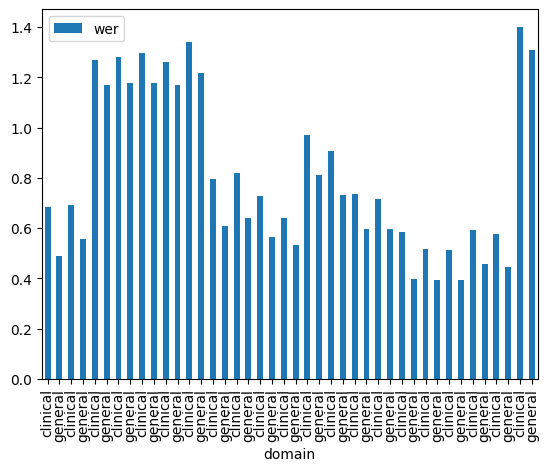

In [136]:
models_df.groupby(["name", "domain"])["wer"].mean().reset_index().plot(kind="bar", x="domain", y="wer", stacked=True)

In [146]:
domain_df = models_df.groupby(["name", "domain"])["wer"].mean().reset_index().set_index("name").pivot(columns="domain").sort_values(("wer", "clinical"))
domain_df

wer          
domain                                          clinical   general
name                                                              
openai_whisper_medium_en                        0.513241  0.392722
openai_whisper_medium                           0.516791  0.395027
openai_whisper_small_en                         0.576405  0.444674
openai_whisper_large                            0.584156  0.397843
openai_whisper_small                            0.591087  0.457932
microsoft_azure_speech_api                      0.640265  0.534663
amazon_aws_transcribe_api                       0.682376  0.489211
amazon_aws_transcribe_medical_api_primary_care  0.692515  0.558258
nvidia_nemo_conformer_transducer_large          0.714832  0.596251
google_gcp_speech_api                           0.727454  0.562984
nvidia_nemo_conformer_ctc_large                 0.736474  0.597584
facebook_wav2vec2_large_xlsr_53_english         0.794567  0.609994
facebook_wav2vec2_xls_r_1b_english              0.821028  0.639466
microsoft_wavlm_libri_clean_100h_large          0.908866  0.731839
microsoft_wavlm_libri_clean_100h_base           0.970380  0.812023
facebook_wav2vec2_large_960h_lv60_self          1.261808  1.171305
facebook_hubert_large_ls960_ft                  1.268739  1.171576
facebook_hubert_xlarge_ls960_ft                 1.281888  1.175639
facebook_wav2vec2_large_960h                    1.298549  1.177514
facebook_wav2vec2_large_robust_ft_swbd_300h     1.340119  1.218940
speechbrain_crdnn_rnnlm_librispeech             1.401104  1.308147

In [147]:
domain_df_clean = models_df_clean.groupby(["name", "domain"])["wer"].mean().reset_index().set_index("name").pivot(columns="domain").sort_values(("wer", "clinical"))
domain_df_clean

wer          
domain                                          clinical   general
name                                                              
openai_whisper_medium                           0.389489  0.295756
openai_whisper_medium_en                        0.408459  0.314095
openai_whisper_small                            0.479648  0.367395
openai_whisper_large                            0.480337  0.318953
openai_whisper_small_en                         0.481420  0.371298
microsoft_azure_speech_api                      0.558557  0.461920
nvidia_nemo_conformer_transducer_large          0.581295  0.449387
amazon_aws_transcribe_api                       0.590611  0.377333
amazon_aws_transcribe_medical_api_primary_care  0.595340  0.457006
nvidia_nemo_conformer_ctc_large                 0.613789  0.466301
google_gcp_speech_api                           0.668108  0.508249
facebook_wav2vec2_large_xlsr_53_english         0.721475  0.531517
facebook_wav2vec2_xls_r_1b_english              0.732908  0.543399
facebook_wav2vec2_large_960h_lv60_self          0.758213  0.555646
facebook_hubert_large_ls960_ft                  0.791780  0.598394
facebook_hubert_xlarge_ls960_ft                 0.806130  0.594111
microsoft_wavlm_libri_clean_100h_large          0.848616  0.663793
facebook_wav2vec2_large_960h                    0.883101  0.665349
microsoft_wavlm_libri_clean_100h_base           0.925856  0.761130
facebook_wav2vec2_large_robust_ft_swbd_300h     0.957995  0.738351
speechbrain_crdnn_rnnlm_librispeech             1.044089  0.886930

In [156]:
accent_df_clean = models_df_clean.groupby(["name", "accent"])["wer"].mean().reset_index().set_index("name").pivot(columns="accent").sort_values(("wer", "english"))
accent_df_clean

wer               \
accent                                         afrikaans akan (fante)   
name                                                                    
openai_whisper_medium_en                        0.198070     0.533970   
openai_whisper_small                            0.237669     0.588375   
openai_whisper_medium                           0.174073     0.629964   
openai_whisper_small_en                         0.258643     0.623728   
openai_whisper_large                            0.264964     0.557184   
google_gcp_speech_api                           0.495920     0.838000   
amazon_aws_transcribe_medical_api_primary_care  0.436241     0.723121   
amazon_aws_transcribe_api                       0.393327     0.647294   
nvidia_nemo_conformer_ctc_large                 0.396220     0.678165   
nvidia_nemo_conformer_transducer_large          0.326000     0.615590   
facebook_wav2vec2_large_xlsr_53_english         0.598225     0.668733   
facebook_wav2vec2_xls_r_1b_english              0.581101     0.786899   
facebook_wav2vec2_large_960h_lv60_self          0.550392     0.761614   
facebook_hubert_xlarge_ls960_ft                 0.576721     0.790730   
facebook_hubert_large_ls960_ft                  0.565803     0.838575   
microsoft_wavlm_libri_clean_100h_large          0.678846     0.910941   
facebook_wav2vec2_large_960h                    0.633135     0.885954   
microsoft_wavlm_libri_clean_100h_base           0.759851     0.943003   
facebook_wav2vec2_large_robust_ft_swbd_300h     0.709120     0.955501   
microsoft_azure_speech_api                      0.367236     0.589705   
speechbrain_crdnn_rnnlm_librispeech             0.706448     1.157307   

                                                                         \
accent                                            anaang bassa-nge/nupe   
name                                                                      
openai_whisper_medium_en                        0.189572       0.515491   
openai_whisper_small                            0.211222       0.565023   
openai_whisper_medium                           0.194381       0.496533   
openai_whisper_small_en                         0.251596       0.581684   
openai_whisper_large                            0.313009       0.412546   
google_gcp_speech_api                           0.339406       0.668007   
amazon_aws_transcribe_medical_api_primary_care  0.352191       0.458708   
amazon_aws_transcribe_api                       0.242981       0.439477   
nvidia_nemo_conformer_ctc_large                 0.327825       0.465788   
nvidia_nemo_conformer_transducer_large          0.393462       0.556186   
facebook_wav2vec2_large_xlsr_53_english         0.449124       0.611659   
facebook_wav2vec2_xls_r_1b_english              0.465954       0.617760   
facebook_wav2vec2_large_960h_lv60_self          0.420229       0.643864   
facebook_hubert_xlarge_ls960_ft                 0.469026       0.698668   
facebook_hubert_large_ls960_ft                  0.472350       0.543643   
microsoft_wavlm_libri_clean_100h_large          0.590811       0.687526   
facebook_wav2vec2_large_960h                    0.517724       0.744623   
microsoft_wavlm_libri_clean_100h_base           0.628925       0.835079   
facebook_wav2vec2_large_robust_ft_swbd_300h     0.598190       0.836609   
microsoft_azure_speech_api                      1.000000       1.000000   
speechbrain_crdnn_rnnlm_librispeech             0.690107       0.932396   

                                                                              \
accent                                             berom     ebira       edo   
name                                                                           
openai_whisper_medium_en                        0.597518  0.219789  0.663440   
openai_whisper_small                            0.598683  0.211701  0.781191   
openai_whisper_medium                           0.596334  0.231891  0.563902   
openai_whisper_smal